# 2. Import required library

In [ ]:
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS

# 3. Read dataset and do pre-processing


In [ ]:
df = pd.read_csv('/content/spam.csv',encoding = "ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


(-0.5, 1599.5, 799.5, -0.5)

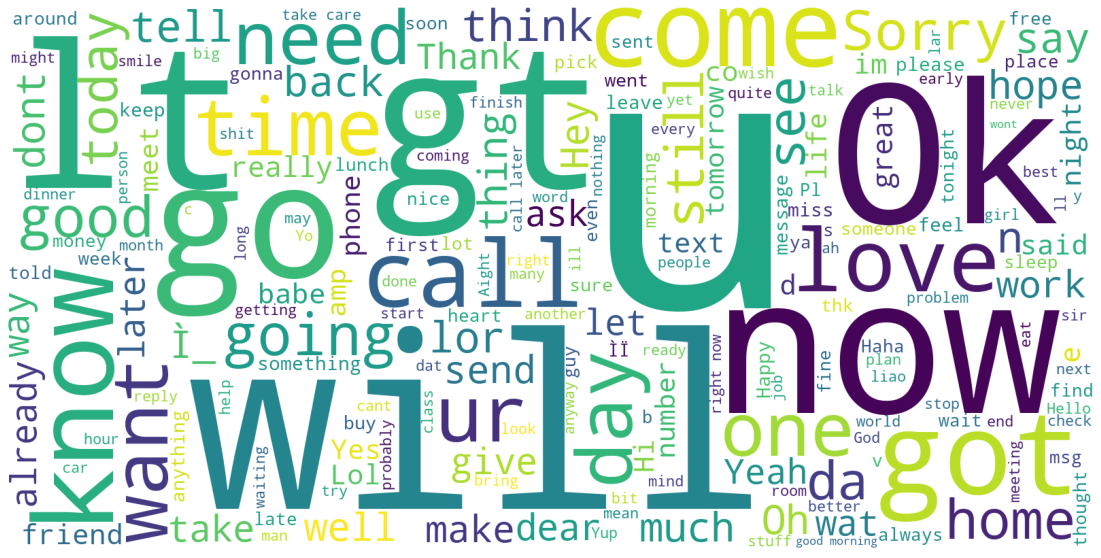

In [ ]:
ms1 = pd.Series((df.loc[df['v1']=='ham','v2']).tolist()).astype(str)
wordcloud = WordCloud(stopwords=STOPWORDS,width=1600,height=800,background_color='white').generate(" ".join(ms1))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 1599.5, 799.5, -0.5)

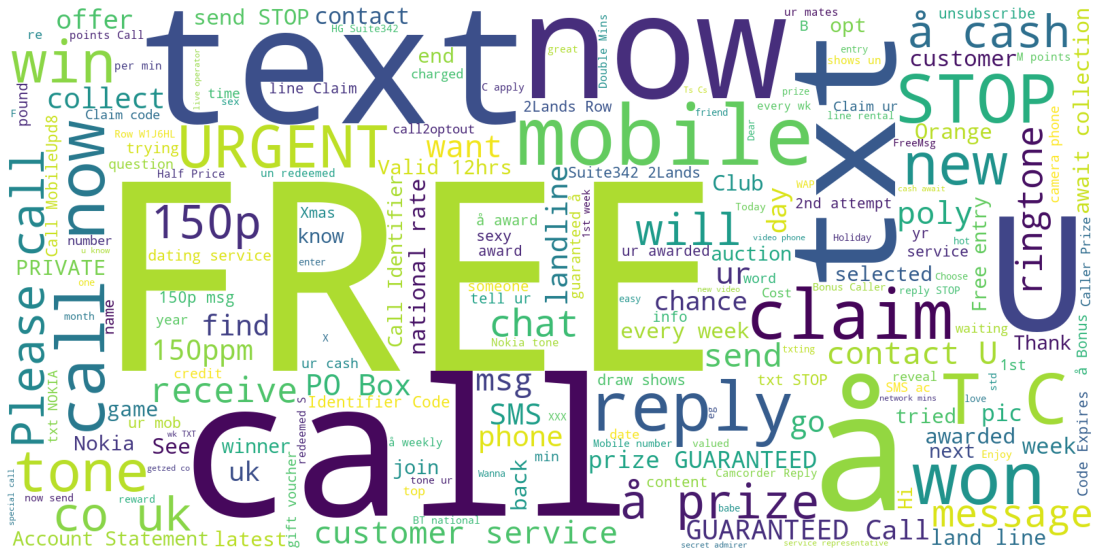

In [ ]:
ms2 = pd.Series((df.loc[df['v1']=='spam','v2']).tolist()).astype(str)
wordcloud = WordCloud(stopwords=STOPWORDS,width=1600,height=800,background_color='white').generate(" ".join(ms2))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')

In [ ]:
lemmatizer = WordNetLemmatizer()
corpus = []

In [ ]:
for i in range(len(df)):
    review = re.sub('[^a-zA-Z]',' ',df['v2'][i])
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(i) for i in review if not i in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

# 4. Create Model

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense,Dropout,LSTM,Embedding
from keras.models import Sequential,load_model

In [ ]:
token = Tokenizer()
token.fit_on_texts(corpus)
text_to_seq = token.texts_to_sequences(corpus)

In [ ]:
max_length_sequence = max([len(i) for i in text_to_seq])
padded_seq = pad_sequences(text_to_seq, maxlen=max_length_sequence, padding="pre")

In [ ]:
padded_seq

array([[   0,    0,    0, ...,   16, 3551,   70],
       [   0,    0,    0, ...,  359,    1, 1610],
       [   0,    0,    0, ...,  218,   29,  293],
       ...,
       [   0,    0,    0, ..., 7042, 1095, 3547],
       [   0,    0,    0, ...,  842,    1,   10],
       [   0,    0,    0, ..., 2198,  347,  152]], dtype=int32)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['v1'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(padded_seq,y,test_size=0.25,random_state=42)

In [ ]:
X_train.shape

(4179, 77)

# 5. Add Layers

In [ ]:
TOT_SIZE = len(token.word_index) + 1
model = Sequential()
#IP Layer
model.add(Embedding(TOT_SIZE,32,input_length=max_length_sequence))
model.add(LSTM(units=50, activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
#Layer2
model.add(LSTM(units=60, activation = 'relu'))
model.add(Dropout(0.3))
#output layer
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 77, 32)            225408    
                                                                 
 lstm (LSTM)                 (None, 77, 50)            16600     
                                                                 
 dropout (Dropout)           (None, 77, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60)                26640     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 268,709
Trainable params: 268,709
Non-trai

# 6,7 Compile and Fit the model

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=10)

Epoch 1/10
131/131 [==============================] - 16s 95ms/step - loss: 0.3271 - accuracy: 0.8775 - val_loss: 0.2005 - val_accuracy: 0.9698
Epoch 2/10
131/131 [==============================] - 12s 90ms/step - loss: 0.7912 - accuracy: 0.9782 - val_loss: 137.2025 - val_accuracy: 0.9756
Epoch 3/10
131/131 [==============================] - 12s 90ms/step - loss: 647.0222 - accuracy: 0.9840 - val_loss: 0.4328 - val_accuracy: 0.9734
Epoch 4/10
131/131 [==============================] - 13s 102ms/step - loss: 0.5835 - accuracy: 0.9842 - val_loss: 0.2534 - val_accuracy: 0.9749
Epoch 5/10
131/131 [==============================] - 15s 116ms/step - loss: 0.2139 - accuracy: 0.9878 - val_loss: 0.2189 - val_accuracy: 0.9742
Epoch 6/10
131/131 [==============================] - 12s 90ms/step - loss: 0.1703 - accuracy: 0.9885 - val_loss: 0.1866 - val_accuracy: 0.9770
Epoch 7/10
131/131 [==============================] - 15s 112ms/step - loss: 0.1466 - accuracy: 0.9911 - val_loss: 0.1666 - val_ac

In [ ]:
model.evaluate(X_test,y_test)

44/44 [==============================] - 1s 22ms/step - loss: 0.2240 - accuracy: 0.9785


[0.22397735714912415, 0.9784637689590454]

# 8.Save the Model

In [ ]:
from pickle import dump,load
tfid = 'tfid.sav'
lstm = 'lstm.sav'

In [ ]:
dump(token,open(tfid,'wb'))
model.save('nlp.h5')

# 9. Test the Model

In [ ]:
def preprocess(raw_mess):
    review = re.sub('[^a-zA-Z]',' ',raw_mess)
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(i) for i in review if not i in set(stopwords.words('english'))]
    review = ' '.join(review)
    return review

In [ ]:
def predict(mess):
    vect = load(open(tfid,'rb'))
    classifier = load_model('nlp.h5')
    clean = preprocess(mess)
    text_to_seq = token.texts_to_sequences([mess])
    padded_seq = pad_sequences(text_to_seq, maxlen=77, padding="pre")
    pred = classifier.predict(padded_seq)
    return pred

In [ ]:
msg = input("Enter a message: ")
predi = predict(msg)
if predi > 0.6:
    print("It is a spam")
else:
    print("Not a spam")

Enter a message: Hey hi how are you?
1/1 [==============================] - 0s 309ms/step
Not a spam


In [ ]:
msg = input("Enter a message: ")
predi = predict(msg)
if predi > 0.6:
    print("It is a spam")
else:
    print("Not a spam")

Enter a message: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
1/1 [==============================] - 0s 302ms/step
It is a spam
